# Simple implementation of Siamese + FSL on FSDD (Free Spoken Digit Dataset)

In [ ]:
#!pip install hub
!pip install "deeplake<4"
#import hub
import deeplake
ds = deeplake.load("hub://activeloop/spoken_mnist")
import torch
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from torch import optim
from torchvision import transforms
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
!pip install tensorboard
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
#mounting drive
from google.colab import drive
drive.mount('/content/drive')
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.7/618.7 kB 24.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 8.0 MB/s eta 0

/usr/local/lib/python3.10/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.0.0) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
/

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist



-

hub://activeloop/spoken_mnist loaded successfully.



Mounted at /content/drive


In [ ]:
#set seed for pytorch
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## Spectrogram visualization

A spectrogram is a visual representation of the spectrum of frequencies in a signal as it varies with time. spectrograms are often used as input features for models, particularly in audio and speech processing tasks.

How to read a spectrgoram?

Observe the x-axis for time progression and the y-axis for frequency, noting that higher frequencies are typically at the top. The color intensity represents the amplitude of the frequencies, where darker areas indicate stronger frequency components at specific times. By analyzing the patterns and changes in color intensity over time, you can interpret the frequency content and dynamics of the audio signal.

<ipython-input-3-549bc7a39b09>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"{ds.speakers[sample].data()['value']} says {int(ds.labels[sample].numpy())}")


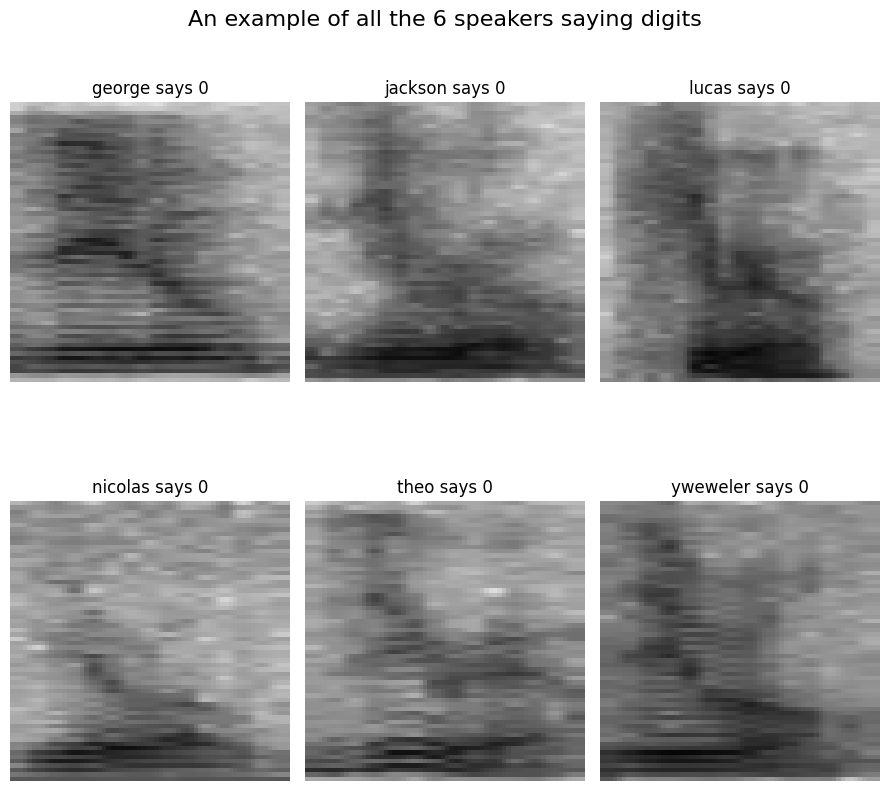

In [ ]:
# a grid of 2x3 spectrogram samples

# Choose 6 samples from 0 to 2999
samples = [5, 55, 105, 155, 205, 255]

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(9, 9))

# Plot each spectrogram in the grid
for i, sample in enumerate(samples):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    # Plot the spectrogram
    ax.imshow(ds.spectrograms[sample].numpy())
    ax.set_title(f"{ds.speakers[sample].data()['value']} says {int(ds.labels[sample].numpy())}")
    ax.axis('off')  # Hide the axis for a cleaner look

# Adjust layout to prevent overlap
plt.tight_layout()
fig.suptitle('An example of all the 6 speakers saying digits', fontsize=16)
plt.show()


In [ ]:
# Listen to the audio:
ds.visualize()

HINT: Please forward the port - 52407 to your local machine, if you are running on the cloud.
 * Serving Flask app 'dataset_visualizer'


 * Debug mode: off


## EDA

In [ ]:
# summary of the data, note: we use the hub library for basic actions, and not pandas as usual
ds.summary()

# shapes of tensors:
# spectrograms - 3000 spectrograms, 64x64 (pixels) where the x axis represents time and y the frequency, 4 represnts 4 channels (RGBA)
# labels - the spoken digit, each label is a single value
# audio - 3000 audio samples, audio length ranges from 1148 time steps to 18262 time steps, 1 channel (mono)
# speakers - the speaker, each time a different speaker

Dataset(path='hub://activeloop/spoken_mnist', read_only=True, tensors=['spectrograms', 'labels', 'audio', 'speakers'])

    tensor        htype             shape           dtype  compression
   -------       -------           -------         -------  ------- 
 spectrograms     image       (3000, 64, 64, 4)     uint8    None   
    labels     class_label        (3000, 1)        uint32    None   
    audio         audio     (3000, 1148:18262, 1)  float64    wav   
   speakers       text            (3000, 1)          str     None   


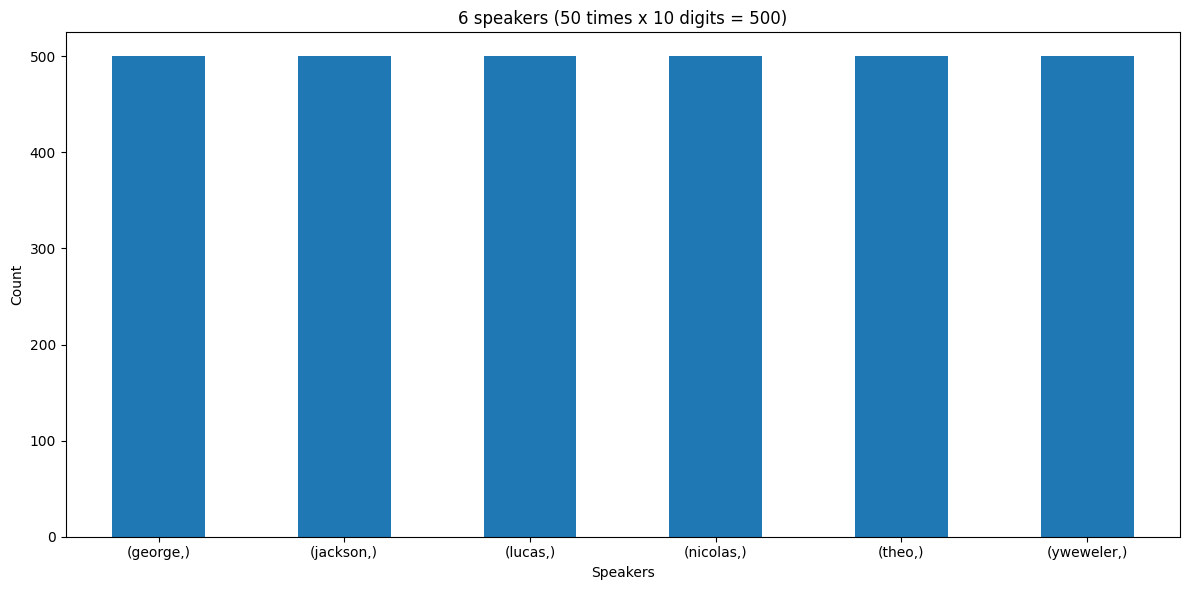

In [ ]:
value_counts_speakers = pd.DataFrame(ds.speakers.data()['value']).value_counts()


plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
value_counts_speakers.plot(kind='bar')

plt.title('6 speakers (50 times x 10 digits = 500)')
plt.xlabel('Speakers')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot

plt.show()

In [ ]:
# external knowledge about the speakers, not included in our data:
# gender and nationality of speakers
metadata = {
    'jackson': {
        'gender': 'male',
        'accent': 'USA/neutral',
        'language': 'english'
    },
    'nicolas': {
    	'gender': 'male',
    	'accent': 'BEL/French',
    	'language': 'english'
    },
    'theo': {
    	'gender': 'male',
    	'accent': 'USA/neutral',
    	'language': 'english'
    },
    'yweweler': {
    	'gender': 'male',
    	'accent': 'DEU/German',
    	'language': 'english'
    },
    'george': {
        'gender': 'male',
        'accent': 'GRC/Greek',
        'language': 'english'
    },
    'lucas': {
        'gender': 'male',
        'accent': 'DEU/German',
        'language': 'english'
    }
}

# we can see some info about our speakers, such as gender and nationality (accent)
# all speakers are males
# 2 with an American accent, 2 with a German accent, 1 with a Greek accent, and 1 with a French accent
metadata

{'jackson': {'gender': 'male', 'accent': 'USA/neutral', 'language': 'english'},
 'nicolas': {'gender': 'male', 'accent': 'BEL/French', 'language': 'english'},
 'theo': {'gender': 'male', 'accent': 'USA/neutral', 'language': 'english'},
 'yweweler': {'gender': 'male', 'accent': 'DEU/German', 'language': 'english'},
 'george': {'gender': 'male', 'accent': 'GRC/Greek', 'language': 'english'},
 'lucas': {'gender': 'male', 'accent': 'DEU/German', 'language': 'english'}}

## Task 3 - Siamese Triplets

Train the model only on digits 0-7 and test the model on all digits and see how it clusters the new digits based on the similarity learning of the other digits learned during training

### Triplets Generation

Create a function that generates triplets of samples (Anchor, Positive, Negative)

In [ ]:
def generate_triplets(images, labels):
  triplets = []
  for i in set(labels):
    same_class = np.where(labels == i)[0] # list
    diff_class = np.where(labels != i)[0]
    for anchor in same_class:
      positive = np.random.choice(same_class) # picks a random index from same class
      negative = np.random.choice(diff_class) # """" diff class
      triplets.append((anchor, positive, negative))
  return triplets

In [ ]:
# lets create a Dataset class that permutes the dimensions
class MyDataset(Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    return self.images[index].permute(2,0,1), self.labels[index] # permutes the dimensions

### Split train/val/test

Splitting train - test (0.7/0.3) and then test val (0.15/0.15)
in the 2nd step - remove digits 8 and 9 from the train and val.
outcome:
train - 0-7
val - 0-7
test - 0-9

In [ ]:
# creates a regular train and test set
S_images = torch.tensor(ds.spectrograms.numpy(), dtype = torch.float32)
S_labels = torch.tensor(ds.labels.numpy(), dtype = torch.long).squeeze()
S_train_images, S_test_val_images, S_train_labels, S_test_val_labels = train_test_split(S_images, S_labels, test_size = 0.3, stratify = S_labels)

In [ ]:
# split the test to val and test
S_val_images, S_test_images, S_val_labels, S_test_labels = train_test_split(S_test_val_images, S_test_val_labels, test_size = 0.5, stratify = S_test_val_labels)

In [ ]:
S_val_images.shape

torch.Size([450, 64, 64, 4])

In [ ]:
# define how many digits should the model be exposed to during training
num_digits = 8 #first X-11 digits

S_train_indices = np.isin(S_train_labels, range(num_digits)) # create the filter based on the indices
S_val_indices = np.isin(S_val_labels, range(10)) # validation will be on all digits

# apply mask

S_train_images_digits = S_train_images[S_train_indices]
S_train_labels_digits = S_train_labels[S_train_indices]

S_val_images_digits = S_val_images[S_val_indices]
S_val_labels_digits = S_val_labels[S_val_indices]

In [ ]:
# apply generate triplets function to get triplets indices - only on the train set, as the validation and test will be in few-shot-learning format
S_train_digits_triplets_indices = generate_triplets(S_train_images_digits, S_train_labels_digits) # train indices

In [ ]:
print(f'train size with digits 0 - {num_digits-1}: {S_train_labels_digits.shape[0]}\nval size with digits 0 - 9: {S_val_labels_digits.shape[0]}')

train size with digits 0 - 7: 1680
val size with digits 0 - 9: 450


### Dataset and Dataloader

In [ ]:
class TripletDataset(Dataset):
    def __init__(self, spectrograms, triplets):
        self.spectrograms = spectrograms
        self.triplets = triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor_idx, pos_idx, neg_idx = self.triplets[idx]
        anchor = self.spectrograms[anchor_idx].permute(2,0,1) # define anchor + premute dimensions
        positive = self.spectrograms[pos_idx].permute(2,0,1) # """"
        negative = self.spectrograms[neg_idx].permute(2,0,1) # """"
        return anchor, positive, negative

In [ ]:
S_train_digits_triplets_dataset = TripletDataset(S_train_images_digits, S_train_digits_triplets_indices) # Dataset
S_train_digits_triplets_dataloader = DataLoader(S_train_digits_triplets_dataset, batch_size = 256, shuffle = True) # DataLoader

dataset_val = MyDataset(S_val_images_digits, S_val_labels_digits)
dataloader_val = DataLoader(dataset_val, batch_size = 1024, shuffle = True)

In [ ]:
print('train dataloader in the format of triplets:')
print(f'anchor batch shape:{next(iter(S_train_digits_triplets_dataloader))[0].shape}')
print(f'positive batch shape:{next(iter(S_train_digits_triplets_dataloader))[1].shape}')
print(f'negative batchs hape:{next(iter(S_train_digits_triplets_dataloader))[2].shape}')

train dataloader in the format of triplets:
anchor batch shape:torch.Size([256, 4, 64, 64])
positive batch shape:torch.Size([256, 4, 64, 64])
negative batchs hape:torch.Size([256, 4, 64, 64])


### Siamese Architecture

In [ ]:
class Siamese(nn.Module):
  def __init__(self):
    super(Siamese, self).__init__()

    self.embedding = nn.Sequential(
        # input (*, 4, 64, 64)
        nn.Conv2d(4, 16, (5, 5), padding=2),
        nn.LeakyReLU(negative_slope=0.01),
        nn.MaxPool2d((2, 2)),
        nn.Conv2d(16, 32, (3, 3), padding=1),
        nn.LeakyReLU(negative_slope=0.01),
        nn.MaxPool2d((2, 2)),
        nn.Conv2d(32, 64, (3, 3), padding=1),
        nn.LeakyReLU(negative_slope=0.01),
        nn.MaxPool2d((2, 2)),
        nn.Conv2d(64, 128, (3, 3), padding=1),
        nn.LeakyReLU(negative_slope=0.01),
        nn.MaxPool2d((2, 2)),
        nn.Conv2d(128, 256, (3, 3), padding=1),
        nn.LeakyReLU(negative_slope=0.01),
        nn.MaxPool2d((2, 2)),
        nn.Flatten(),
        nn.Linear(1024, 512),
        nn.LeakyReLU(negative_slope=0.01),
        nn.Dropout(0.5),
        nn.Linear(512, 256),
        nn.LeakyReLU(negative_slope=0.01),
        nn.Dropout(0.5),
        nn.Linear(256, 128) # output is embedding representation of the spectrogram, not a classifier
    )

  def forward(self, x): # forward one image at a time
    return self.embedding(x)




### Triplet Loss

In [ ]:
class TripletLoss(nn.Module):
  def __init__(self, margin = 0.5):
    super(TripletLoss, self).__init__()
    self.margin = margin

  def forward(self, anchor, positive, negative):
    positive_dist = (anchor - positive).pow(2).sum(1) # calc positive distance
    negative_dist = (anchor - negative).pow(2).sum(1) # calc negative distance
    losses = F.relu(positive_dist - negative_dist + self.margin) # applying relu to the triple loss function - negatives become zeros and non negative stays the same
    return losses.mean()


In [ ]:
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Train network

In [ ]:
epochs = 5  # Or however many epochs you want
model = Siamese()
criterion = TripletLoss(margin=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

save_dir = '/content/drive/MyDrive/siamese_model'
os.makedirs(save_dir, exist_ok=True)

# set conditions for early stopping
best_loss = float('inf')
patience = 0
max_patience = 1

train_losses, val_losses = [], []

for epoch in range(epochs):
    # train
    model.train()
    running_loss = 0

    for anchor, positive, negative in tqdm.tqdm(S_train_digits_triplets_dataloader, desc='train'):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()
        anchor_out = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(S_train_digits_triplets_dataloader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs} | train loss: {epoch_loss:.4f}")

    # Check if loss is increasing
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience = 0
        # Save the best model
        best_model_path = os.path.join(save_dir, 'siamese_model_best.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved to {best_model_path}")
    else:
        patience += 1

    if patience >= max_patience:
        print(f"Early stopping triggered. Loss has not improved for {max_patience} consecutive epochs.")
        break

# Save the final model
final_save_path = os.path.join(save_dir, 'siamese_model_final.pth')
torch.save(model.state_dict(), final_save_path)
print(f"Final model weights saved to {final_save_path}")

train: 100%|██████████| 1379/1379 [03:27<00:00,  6.66it/s]


Epoch 1/5 | train loss: 0.1092
New best model saved to /content/drive/MyDrive/siamese_model/siamese_model_best.pth


train: 100%|██████████| 1379/1379 [03:25<00:00,  6.72it/s]


Epoch 2/5 | train loss: 0.0049
New best model saved to /content/drive/MyDrive/siamese_model/siamese_model_best.pth


train: 100%|██████████| 1379/1379 [03:24<00:00,  6.74it/s]


Epoch 3/5 | train loss: 0.0038
New best model saved to /content/drive/MyDrive/siamese_model/siamese_model_best.pth


train: 100%|██████████| 1379/1379 [03:24<00:00,  6.76it/s]


Epoch 4/5 | train loss: 0.0050
Early stopping triggered. Loss has not improved for 1 consecutive epochs.
Final model weights saved to /content/drive/MyDrive/siamese_model/siamese_model_final.pth


### Embedding space

<ipython-input-18-b68f7b9687fe>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location = device))


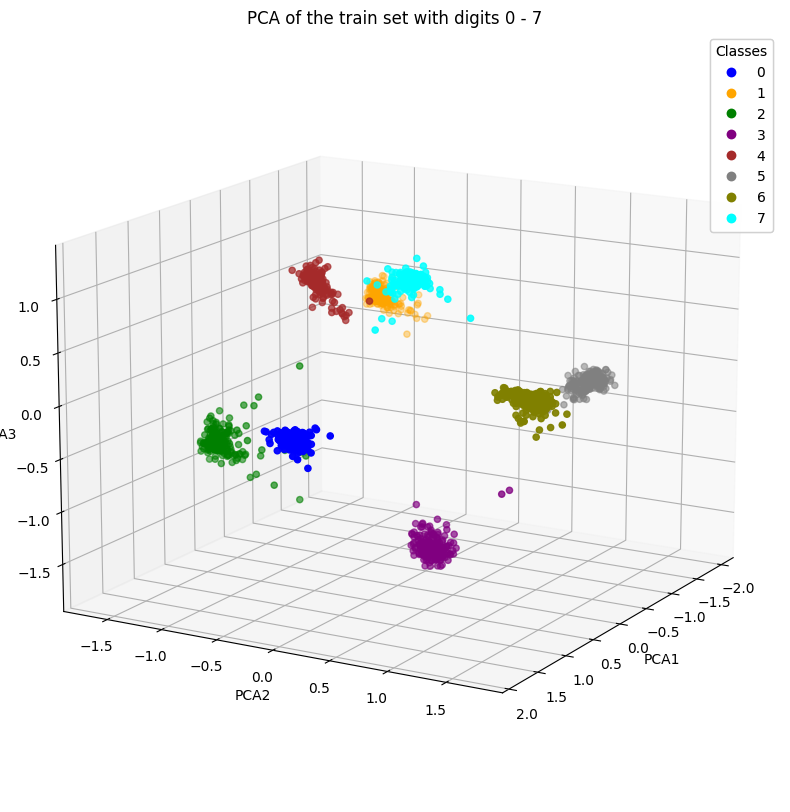

In [ ]:
# lets check the embedding space of the trained dataset

spectrograms = S_train_digits_triplets_dataset.spectrograms
labels = S_train_labels_digits.tolist()

model_path = '/content/drive/MyDrive/siamese_model/siamese_model_final.pth'
model = Siamese()
model.load_state_dict(torch.load(model_path, map_location = device))
model.to(device)

model.eval()
with torch.no_grad():
  l = [] # stores the embedding space
  for i in spectrograms:
    l.append(model(i.permute(2,0,1).unsqueeze(0).to(device)))


# Convert list of tensors to a single numpy array
embeddings = torch.cat(l, dim=0).cpu().numpy()

# Apply PCA
pca = PCA(3) # 3d dimension
embeddings_3d = pca.fit_transform(embeddings)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Define colors for digits 0-9
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
custom_cmap = ListedColormap(colors)

# Create a scatter plot with colors based on class
scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],
                     c=labels, cmap=custom_cmap)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title(f'PCA of the train set with digits 0 - {num_digits-1}')

ax.view_init(elev=15, azim=30)  # View point

# Add a discrete legend
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

plt.show()

### FSL Support & Query Sets

In [ ]:
# the few shot learning pool
few_shot_ds = next(iter(dataloader_val)) # dataloader is big enough for all labels

In [ ]:
def support_set(images, labels, n_way, k_shot=5):
    support_images = []
    support_labels = []
    for digit in range(n_way):
        digit_indices = np.where(labels == digit)[0]
        selected_indices = np.random.choice(digit_indices, k_shot, replace=False)
        support_images.append(torch.tensor(images[selected_indices]))
        support_labels.extend([digit] * k_shot)
    return torch.cat(support_images), torch.tensor(support_labels)

In [ ]:
n_way = 10 # 10 classes included in the validation
k_shot = 5 # samples per class

sup_images, sup_labels = support_set(few_shot_ds[0], few_shot_ds[1], n_way = n_way, k_shot = k_shot)

<ipython-input-29-6af7628efdf9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  support_images.append(torch.tensor(images[selected_indices]))


In [ ]:
def query_set(images, labels, n_query=100):
    query_indices = np.random.choice(range(len(images)), n_query, replace=False)
    return images[query_indices], labels[query_indices]

In [ ]:
n_query = 50 # tasks

query_images, query_labels = query_set(few_shot_ds[0], few_shot_ds[1], n_query = n_query)

### FSL Evaluation

In [ ]:
def evaluate_few_shot(model_path, support_images, support_labels, query_images, query_labels, n_way=10, k_shot=5, epochs=5, lr=0.0005, patience=7):
    model = Siamese()  # to extract the weights from the siamese model
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.train()  # sets to train mode to be able to update weights

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_accuracy = 0
    best_epoch = 0
    epochs_no_improve = 0
    best_predictions = None

    for epoch in range(epochs):
        optimizer.zero_grad()

        support_features = model(support_images.to(device))
        query_features = model(query_images.to(device))

        distances = torch.cdist(query_features, support_features)
        _, indices = distances.topk(k_shot, largest=False, dim=1)
        support_labels = support_labels.to(device)
        nearest_labels = support_labels[indices]

        # Compute prototype for each class
        class_prototypes = torch.zeros(n_way, support_features.shape[1]).to(device)
        for i in range(n_way):
            class_mask = (support_labels == i).unsqueeze(1).to(device)
            class_prototypes[i] = (support_features * class_mask).sum(0) / class_mask.sum()

        # Compute logits as negative distances to prototypes
        logits = -torch.cdist(query_features, class_prototypes)

        # Compute loss
        loss = criterion(logits, query_labels.to(device))

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Make predictions
        _, predictions = torch.max(logits, 1)

        # Calculate accuracy
        accuracy = accuracy_score(query_labels.cpu(), predictions.cpu())

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

        # Early stopping check
        if accuracy >= best_accuracy:
            best_accuracy = accuracy
            best_epoch = epoch
            epochs_no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_model.pth')
            # Save the best predictions
            best_predictions = predictions.cpu()
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered. Best epoch: {best_epoch+1} with accuracy: {best_accuracy:.4f}")
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))
    return best_accuracy, best_predictions, query_labels

In [ ]:
model_path = '/content/drive/MyDrive/siamese_model/siamese_model_final.pth'
acc, predictions, true_labels = evaluate_few_shot(model_path, sup_images, sup_labels, query_images, query_labels, n_way = n_way, k_shot = k_shot, epochs = 20)

<ipython-input-33-de9b48e95e01>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Epoch 1/20, Loss: 1.0574, Accuracy: 0.8400
Epoch 2/20, Loss: 1.0055, Accuracy: 0.8400
Epoch 3/20, Loss: 0.8934, Accuracy: 0.8200
Epoch 4/20, Loss: 0.7821, Accuracy: 0.9400
Epoch 5/20, Loss: 0.7845, Accuracy: 0.8600
Epoch 6/20, Loss: 0.6353, Accuracy: 0.9000
Epoch 7/20, Loss: 0.5489, Accuracy: 0.8600
Epoch 8/20, Loss: 0.5423, Accuracy: 0.9200
Epoch 9/20, Loss: 0.4617, Accuracy: 0.9000
Epoch 10/20, Loss: 0.3647, Accuracy: 0.9400
Epoch 11/20, Loss: 0.3582, Accuracy: 0.8400
Epoch 12/20, Loss: 0.2765, Accuracy: 0.9200
Epoch 13/20, Loss: 0.2518, Accuracy: 0.9400
Epoch 14/20, Loss: 0.2505, Accuracy: 0.9200
Epoch 15/20, Loss: 0.1951, Accuracy: 0.9000
Epoch 16/20, Loss: 0.1842, Accuracy: 0.9200
Epoch 17/20, Loss: 0.1174, Accuracy: 0.9600
Epoch 18/20, Loss: 0.2074, Accuracy: 0.8800
Epoch 19/20, Loss: 0.1777, Accuracy: 0.9000
Epoch 20/20, Loss: 0.1499, Accuracy: 0.9000


<ipython-input-33-de9b48e95e01>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [ ]:
print(f'pred:\n{predictions}')
print(f'true labels:\n{true_labels}')

pred:
tensor([5, 8, 8, 6, 3, 2, 7, 7, 4, 4, 9, 4, 2, 9, 9, 4, 2, 2, 5, 3, 4, 8, 5, 9,
        9, 0, 2, 4, 5, 8, 7, 8, 6, 3, 3, 1, 0, 7, 2, 8, 4, 9, 2, 8, 5, 7, 4, 4,
        0, 4])
true labels:
tensor([5, 8, 8, 6, 3, 2, 7, 9, 4, 4, 9, 4, 2, 9, 9, 4, 2, 2, 5, 3, 4, 8, 5, 9,
        9, 0, 2, 4, 5, 8, 7, 6, 6, 3, 3, 1, 0, 7, 2, 8, 4, 9, 2, 8, 5, 7, 4, 4,
        0, 4])


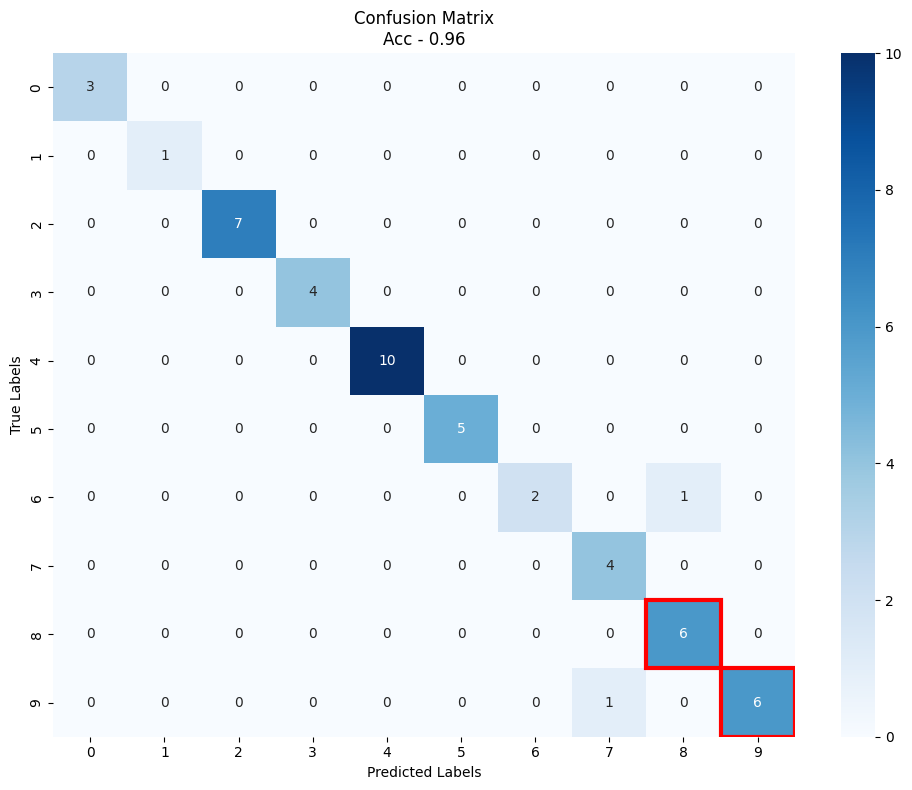

In [ ]:
# Convert tensors to numpy arrays
true_labels_np = true_labels.numpy()
pred_labels_np = predictions.numpy()

# Create the confusion matrix
cm = confusion_matrix(true_labels_np, pred_labels_np, labels=range(10))

# Create the plot
plt.figure(figsize=(10, 8))

# Create the basic heatmap
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add red edges to diagonal cells for digits 8 and 9
for idx in [8, 9]:
    ax.add_patch(plt.Rectangle((idx, idx), 1, 1, fill=False, edgecolor='red', linewidth=3))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix\nAcc - {acc:.2f}')

plt.tight_layout()
plt.show()

In [ ]:
S_test_digits_triplets = generate_triplets(S_test_images, S_test_labels) # train indices
S_test_digits_triplets_dataset = TripletDataset(S_test_images, S_test_digits_triplets) # Dataset
S_test_digits_triplets_dataloader = DataLoader(S_test_digits_triplets_dataset, batch_size = 256, shuffle = True) # DataLoader

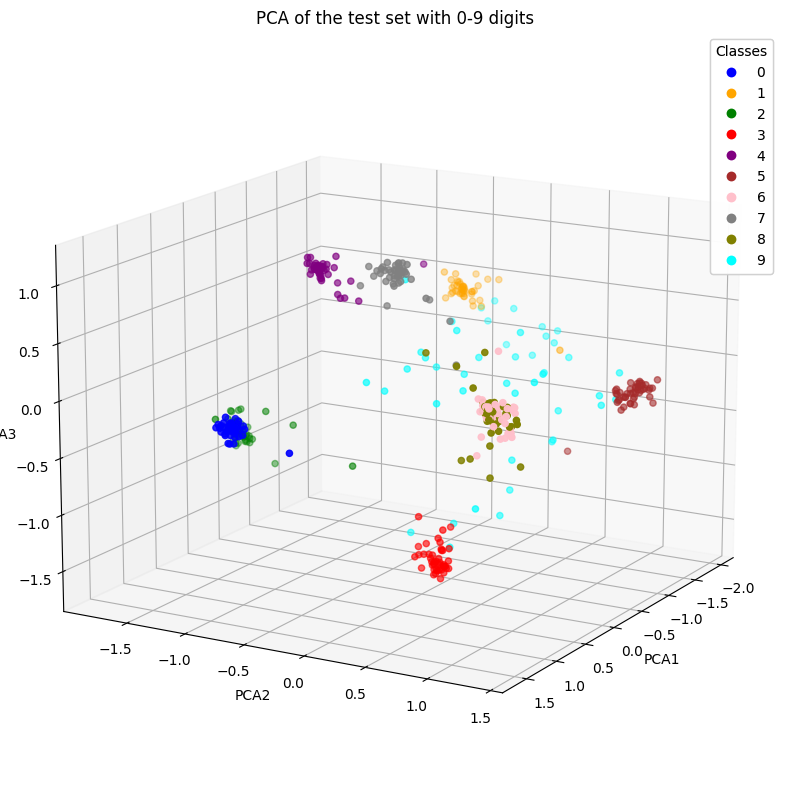

In [ ]:
# now test to see how the model classifies on all digits
# Second visualization (0-9 classes)
spectrograms = S_test_digits_triplets_dataset.spectrograms
labels = S_test_labels.tolist()

with torch.no_grad():
    l = []  # stores the embedding space
    for i in spectrograms:
        l.append(model(i.permute(2, 0, 1).unsqueeze(0).to(device)))

# Convert list of tensors to a single numpy array
embeddings = torch.cat(l, dim=0).cpu().numpy()

# Apply PCA
pca = PCA(3)  # 3D dimension
embeddings_3d = pca.fit_transform(embeddings)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot with colors based on class
scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],
                     c=labels, cmap=custom_cmap, vmin=0, vmax=9)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('PCA of the test set with 0-9 digits')

ax.view_init(elev=15, azim=30)  # View point

# Add a discrete legend
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

plt.show()

### Tasks